In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates

# Gathering Data

Set up path to data folder

In [ ]:
#shared_dir_path = os.environ["SHARED_DATA_DIR"] + '/'
shared_dir_path = '' # sub this out for above comment when using in notable
path = shared_dir_path + 'ESDA2_GroupProject_Data/'

Read in glacier area data

In [24]:
file = 'glacier_area.xlsx'
file_path = path + file
glacier_area = pd.read_excel(file_path)

Read in all weather station data

In [188]:
# bring in station data
file = '420800.csv'
file_path = path + file
station_420800 = pd.read_csv(file_path, delimiter=';')

file = '422100.csv'
file_path = path + file
station_422100 = pd.read_csv(file_path, delimiter=';')

file = '425000.csv'
file_path = path + file
station_425000 = pd.read_csv(file_path, delimiter=';')

file = '430100.csv'
file_path = path + file
station_430100 = pd.read_csv(file_path, delimiter=';')

file = '432000.csv'
file_path = path + file
station_432000 = pd.read_csv(file_path, delimiter=';')

file = '436000.csv'
file_path = path + file
station_436000 = pd.read_csv(file_path, delimiter=';')

file = 'station_details.xlsx'
file_path = path + file
station_details = pd.read_excel(file_path)

Read in SST data and separate into numpy arrays

In [89]:
file = 'HadISST_SST_northatlantic.nc'
file_path = path + file
ds = nc.Dataset(file_path)

sst_timedelta = ds.variables['time'][:]
sst_lat = ds.variables['latitude'][:]
sst_lon = ds.variables['longitude'][:]
sst = ds.variables['sst'][:,:,:]

We now have pandas dataframes or numpy arrays for all our variables

# Reformatting and Cleaning Data

Make the glacier area in to appropraite timeseries, and a dictionary of each glaciers lat and lon.

In [67]:
# make a df of each glaciers location
glacier_locations = glacier_area[['Glacier', 'Latitude', 'Longitude']].set_index('Glacier').T
glacier_locations = glacier_locations.rename(index={'Latitude': 'lat', 'Longitude': 'lon'})
glacier_locations = glacier_locations.to_dict()
print(glacier_locations['Rink Isbrae'])

{'lat': 71.73282971, 'lon': -51.6631661}


In [49]:
glacier_timeseries = glacier_area.drop(['Latitude', 'Longitude'], axis=1).set_index('Glacier').T
glacier_timeseries.index = pd.to_datetime(glacier_timeseries.index)
glacier_timeseries.head()

Glacier,Umiammakku Isbrae,Geikie Unnamed Vestford S,Rink Isbrae,Kangerlussuup Sermersua,Sermeq Silarleq,Cw Noname2,Lille Gletscher,Store Gletscher,Sermeq Avannarleq2,Narsap Sermia,...,Nordfjord,Styrte,Courtauld,Unnamed Deception N,Kruuse Fjord,Ice Caps Ce,Glacierdefrance,Knud-Rasmussen,Nigertuluup Kattilertarpia,Ice Caps Se
1972-09-15,2316.126692,2720.110833,30000.470567,7659.530459,12065.276036,2538.520698,2537.371493,30273.675460,7992.051332,6380.928283,...,346.096339,411.105516,187.707442,793.373169,1422.079573,7536.075193,385.250416,525.690781,343.936543,1945.481414
1972-10-15,2316.126692,2720.067640,30000.456019,7659.225421,12065.073406,2538.506235,2537.342593,30273.661026,7991.964906,6381.066998,...,346.096339,411.105516,187.793015,792.220908,1421.994782,7536.089455,385.250417,525.368253,343.908438,1944.808804
1972-11-15,2316.126692,2720.053243,30000.456019,7659.051114,12065.102360,2538.506235,2537.313692,30273.661026,7991.907289,6381.053125,...,346.096339,411.105516,187.793015,791.922177,1421.938222,7536.089455,385.264473,525.326185,343.880332,1944.752884
1972-12-15,2316.126692,2720.038846,30000.456019,7658.920384,12065.102376,2538.506235,2537.270346,30273.661026,7991.878480,6381.039252,...,346.096339,411.105516,187.793015,791.595001,1421.895802,7536.089455,385.264472,525.298139,343.852227,1944.724837
1973-01-15,2316.126692,2720.038846,30000.456019,7658.862281,12065.131331,2538.506235,2537.241445,30273.661026,7991.864075,6381.039252,...,346.096339,411.105516,187.793015,791.410075,1421.895802,7536.089455,385.264471,525.270093,343.838175,1944.724837


SST data is stored in 4 arrays: time, lats, lons, and sst. Time is stored as time since 1870-1-1 0:0:0. We will convert these times then to appropriate timestamps.

In [83]:
print(ds['time'])

<class 'netCDF4.Variable'>
float32 time(time)
    units: days since 1870-1-1 0:0:0
    calendar: gregorian
    long_name: Time
    standard_name: time
unlimited dimensions: 
current shape = (1856,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [90]:
sst_time = pd.to_timedelta(sst_timedelta, unit='D') + pd.Timestamp('1870-01-01 00:00:00')
print(sst_time)

DatetimeIndex(['1870-01-16 11:59:59.505615234',
               '1870-02-14 23:59:59.340820315',
               '1870-03-16 11:59:59.340820315',
               '1870-04-15 23:59:59.340820315',
                         '1870-05-16 12:00:00',
                         '1870-06-16 00:00:00',
                         '1870-07-16 12:00:00',
                         '1870-08-16 12:00:00',
                         '1870-09-16 00:00:00',
                         '1870-10-16 12:00:00',
               ...
                         '2023-11-16 00:00:00',
                         '2023-12-16 12:00:00',
                         '2024-01-16 12:00:00',
                         '2024-02-15 12:00:00',
                         '2024-03-16 12:00:00',
                         '2024-04-16 00:00:00',
                         '2024-05-16 12:00:00',
                         '2024-06-16 00:00:00',
                         '2024-07-16 12:00:00',
                         '2024-08-16 12:00:00'],
              dtype=

SST has a lot of masked values for values on land - the functions in the functions section allow us to pick a point closest to the glacier with data. However, at certain timestamps the SST is given as -1000 for different glaciers. Cleaning that we do:

In [161]:
mask_value = -1000.0
freezing_point = -1.8
sst[sst == mask_value] = freezing_point

Now we simplify our metdata for each station, and creat a dictionary to access

In [191]:
metdata_420800 = station_420800.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_420800['Date'] = pd.to_datetime(metdata_420800[['Year', 'Month', 'Day', 'Hour']])
metdata_420800 = metdata_420800.set_index('Date')
metdata_420800 = metdata_420800[['airtemp']]

metdata_422100 = station_422100.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_422100['Date'] = pd.to_datetime(metdata_422100[['Year', 'Month', 'Day', 'Hour']])
metdata_422100 = metdata_422100.set_index('Date')
metdata_422100 = metdata_422100[['airtemp']]

metdata_425000 = station_425000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_425000['Date'] = pd.to_datetime(metdata_425000[['Year', 'Month', 'Day', 'Hour']])
metdata_425000 = metdata_425000.set_index('Date')
metdata_425000 = metdata_425000[['airtemp']]

metdata_430100 = station_430100.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_430100['Date'] = pd.to_datetime(metdata_430100[['Year', 'Month', 'Day', 'Hour']])
metdata_430100 = metdata_430100.set_index('Date')
metdata_430100 = metdata_430100[['airtemp']]

metdata_432000 = station_432000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_432000['Date'] = pd.to_datetime(metdata_432000[['Year', 'Month', 'Day', 'Hour']])
metdata_432000 = metdata_432000.set_index('Date')
metdata_432000 = metdata_432000[['airtemp']]

metdata_436000 = station_436000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_436000['Date'] = pd.to_datetime(metdata_436000[['Year', 'Month', 'Day', 'Hour']])
metdata_436000 = metdata_436000.set_index('Date')
metdata_436000 = metdata_436000[['airtemp']]

metdata = {
    '420800': metdata_420800,
    '422100': metdata_422100,
    '425000': metdata_425000,
    '430100': metdata_430100,
    '432000': metdata_432000,
    '436000': metdata_436000
}

## Summary of Data

Glacier:
* glacier_timeseries - pandas DataFrame of all glaciers' area at different timestamps; find single glacier by indexing in with glacier_timeseries[GLACIER]
* glacier_locations - dict of glacier positions; lat = glacier_locations[GLACIER]['lat'], lon = glacier_locations[GLACIER]['lon']

Metdata:
* station_details - pandas DataFrame with information about each station (most crucially location); appropriate station chosen by functions below
* metdata_i (where i is station number) - pandas timeseries of airtemp at station i; note many na values (maintenance, etc) but not cleaned as different ways will be needed for different questions
* metdata - dict of all metdata_i; find station by metdata[STATION NUMBER], where appropriate station number can be found from function below

Sea Surface Temperture:
* sst_time - array of datetimes for sst data
* sst_lat - array of latitutdes of stt data
* sst_lon - array of longitudes of sst data
* sst - 3d array of sst; index in [ind_time, ind_lat, ind_lon]; choose lat and lon index by functions below

# Useful Functions

Function to find the index for the point of sst to glacier.

In [139]:
def pick_closest_SST(lats, lons, sst, glacier):
    """
    lats: 1D array of latitudes
    lons: 1D array of longitudes
    sst: 3D array of sea surface temp at (time, latitude, longitude)
    glacier: (lat, lon); a tuple of glacier coordinates

    returns: ind_lat, ind_lon -> indices to get sst data closest to glacier
    """
    sst_slice = sst[-1, :, :]   # last time step
    mask = sst_slice.mask
    
    lon2d, lat2d = np.meshgrid(lons, lats)
    
    dist = np.sqrt((lat2d - glacier[0])**2 + (lon2d - glacier[1])**2)

    dist_masked = np.ma.array(dist, mask=mask)

    pair = np.unravel_index(np.argmin(dist_masked), dist_masked.shape)

    ind_lat = pair[0]
    ind_lon = pair[1]
    
    return ind_lat, ind_lon

In [105]:
GLACIER = 'Rink Isbrae'
target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])
ind_lat, ind_lon = pick_closest_SST(sst_lat, sst_lon, sst, target_location)
print(ind_lat, ind_lon)
print(sst[:, ind_lat, ind_lon])


18 46
[-1.5146484375 -1.72021484375 -1.7999999523162842 ... 2.065570116043091
 2.2367069721221924 4.495405673980713]


Function to find closest air temp reading to glacier.

In [121]:
def pick_closest_airtemp(station_details, glacier_location):
    """
    station_details: dataframe with columns 'Station Code', 'Latitude', 'Longitude'
    target_lat: latitude of glacier
    target_lon: longitude of glacier

    returns: station_code -> code of closest station
    """
    target_lat, target_lon = glacier_location
    lats = station_details['Latitude'].values
    lons = station_details['Longitude'].values
    station_codes = station_details['Station number'].values

    dist = np.sqrt((lats - target_lat)**2 + (lons - target_lon)**2)

    min_index = np.argmin(dist)

    station_number = station_codes[min_index]

    return station_number   

In [122]:
GLACIER = 'Rink Isbrae'
target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])

station_number = pick_closest_airtemp(station_details, target_location)
print(station_number)

422100


# Getting DataFrames together

# Basic Time Series Plots

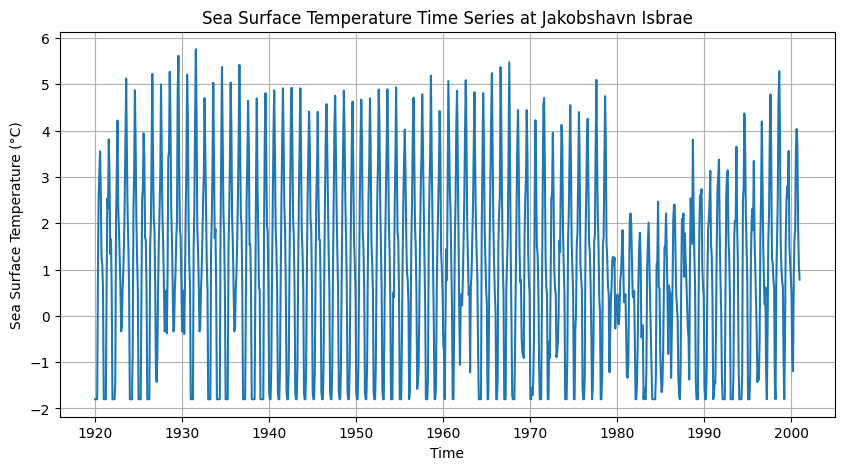

In [167]:
# SST Time Series Plot for glacier of choice, with time restriction
GLACIER = 'Jakobshavn Isbrae'

target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])
ind_lat, ind_lon = pick_closest_SST(sst_lat, sst_lon, sst, target_location)
glacier_sst = sst[:, ind_lat, ind_lon]

restricted_time = (sst_time >= '1920-01-01') & (sst_time <= '2000-12-31')
sst_time_plot = sst_time[restricted_time]
glacier_sst_plot = glacier_sst[restricted_time]

plt.figure(figsize=(10,5))
plt.plot(sst_time_plot, glacier_sst_plot)
plt.title('Sea Surface Temperature Time Series at ' + GLACIER)
plt.xlabel('Time')
plt.ylabel('Sea Surface Temperature (°C)')
plt.grid()
plt.show()

# Maps and Data onto Maps